Solving titanic problem from https://www.kaggle.com/c/titanic/

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("titanic.csv")
data.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


The goal is to predict wether passenger survived, that is value of column "Survived". Protected variable will be "Sex".

In [3]:
X = data.drop(columns=["Survived", "Name"])
X = pd.get_dummies(X)
y = data["Survived"]

print("Number of rows: %d" % len(y))

Number of rows: 887


Let's train and evaluate Random Forest model. Using 20% of data as test set.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3234)
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
acc = np.mean(pred == y_test)
print("Accuracy: %f" % acc)

Accuracy: 0.831461


Now let's examine fairness metrics of trained model.

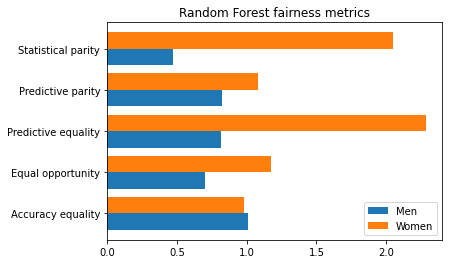

In [5]:
def compute_statistics(y, pred):
    TP = np.sum((pred == 1) & (y == 1))
    FP = np.sum((pred == 1) & (y == 0))
    TN = np.sum((pred == 0) & (y == 0))
    FN = np.sum((pred == 0) & (y == 1))
    accuracy_equality = (TP + TN) / len(y)
    equal_opportunity = TP / (TP + FN)
    predictive_equality = FP / (FP + TN)
    predictive_parity = TP / (TP + FP)
    statistical_parity = (TP + FP) / len(y)
    return np.array([accuracy_equality, equal_opportunity, predictive_equality, predictive_parity, statistical_parity])

def plot_fairness(classifier, X_test, y_test, title):
    X_test_men = X_test[X_test["Sex_male"] == 1]
    pred_men = classifier.predict(X_test_men)
    y_men = y_test[X_test["Sex_male"] == 1]
    X_test_women = X_test[X_test["Sex_female"] == 1]
    pred_women = classifier.predict(X_test_women)
    y_women = y_test[X_test["Sex_female"] == 1]
    pred = classifier.predict(X_test)

    stat_men = compute_statistics(y_men, pred_men)
    stat_women = compute_statistics(y_women, pred_women)
    stat_all = compute_statistics(y_test, pred)
    stat_men /= stat_all
    stat_women /= stat_all

    width = 0.8
    metrics = ["Accuracy equality", "Equal opportunity", "Predictive equality", "Predictive parity", "Statistical parity"]
    x = np.arange(len(metrics)) * 2
    fig, ax = plt.subplots()

    ax.set_title(title)
    p_men = ax.barh(x - width / 2, stat_men, label="Men")
    p_women = ax.barh(x + width / 2, stat_women, label="Women")
    ax.set_yticks(x)
    ax.set_yticklabels(metrics)
    ax.legend()

    plt.show()

plot_fairness(classifier, X_test, y_test, "Random Forest fairness metrics")

Let's train 3 more models: Logistic Regression, Boosting and Neural Network to compare metrics

In [6]:
logistic_classifier = LogisticRegression(max_iter=300).fit(X_train, y_train)
pred_log = logistic_classifier.predict(X_test)
acc = np.mean(pred_log == y_test)
print("Logistic Regression Accuracy: %f" % acc)

boosting_classifier = GradientBoostingClassifier().fit(X_train, y_train)
pred_boost = boosting_classifier.predict(X_test)
acc = np.mean(pred_boost == y_test)
print("Boosting Accuracy: %f" % acc)

neural_classifier = MLPClassifier(max_iter=300).fit(X_train, y_train)
pred_nn = neural_classifier.predict(X_test)
acc = np.mean(pred_nn == y_test)
print("Neural Network Accuracy: %f" % acc)

Logistic Regression Accuracy: 0.786517
Boosting Accuracy: 0.814607
Neural Network Accuracy: 0.820225


Let's now examine their fairness metrics

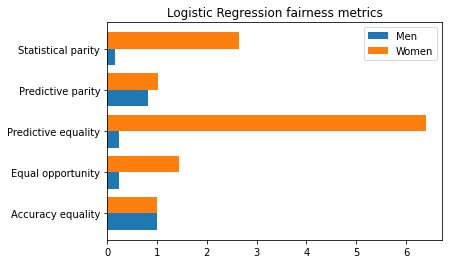

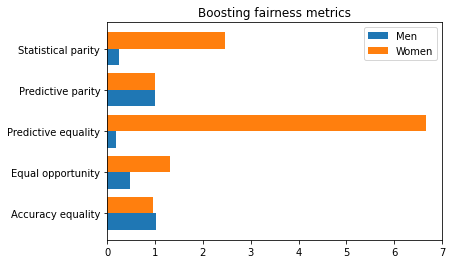

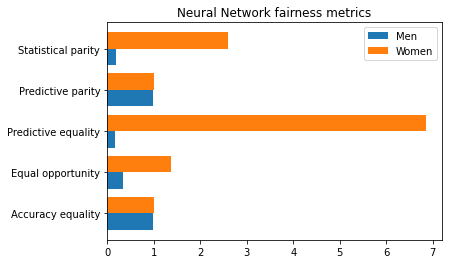

In [7]:
plot_fairness(logistic_classifier, X_test, y_test, "Logistic Regression fairness metrics")
plot_fairness(boosting_classifier, X_test, y_test, "Boosting fairness metrics")
plot_fairness(neural_classifier, X_test, y_test, "Neural Network fairness metrics")

As we see, the results for different networks are quite simillar. The most notable difference is that random forrest has better predictive equality, but it is still quite unbalanced.

For all models predictive equality is very imbalanced, what means that chance of getting false positive result is much higher for women than men. Another imbalanced metrics are Statistical parity, what means that models predict survival of women more often than men, and Equal opportunity, what means that chance of true positive result is higher for women than men. The remaining metrics: Predictive parity and Accuracy equality are balanced, what means that positive result is correct with simillar probability in both groups, and that accuracy is simillar in both groups.

## Appendix: code

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

data = pd.read_csv("titanic.csv")
data.head()

X = data.drop(columns=["Survived", "Name"])
X = pd.get_dummies(X)
y = data["Survived"]

print("Number of rows: %d" % len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3234)
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
acc = np.mean(pred == y_test)
print("Accuracy: %f" % acc)

def compute_statistics(y, pred):
    TP = np.sum((pred == 1) & (y == 1))
    FP = np.sum((pred == 1) & (y == 0))
    TN = np.sum((pred == 0) & (y == 0))
    FN = np.sum((pred == 0) & (y == 1))
    accuracy_equality = (TP + TN) / len(y)
    equal_opportunity = TP / (TP + FN)
    predictive_equality = FP / (FP + TN)
    predictive_parity = TP / (TP + FP)
    statistical_parity = (TP + FP) / len(y)
    return np.array([accuracy_equality, equal_opportunity, predictive_equality, predictive_parity, statistical_parity])

def plot_fairness(classifier, X_test, y_test, title):
    X_test_men = X_test[X_test["Sex_male"] == 1]
    pred_men = classifier.predict(X_test_men)
    y_men = y_test[X_test["Sex_male"] == 1]
    X_test_women = X_test[X_test["Sex_female"] == 1]
    pred_women = classifier.predict(X_test_women)
    y_women = y_test[X_test["Sex_female"] == 1]
    pred = classifier.predict(X_test)

    stat_men = compute_statistics(y_men, pred_men)
    stat_women = compute_statistics(y_women, pred_women)
    stat_all = compute_statistics(y_test, pred)
    stat_men /= stat_all
    stat_women /= stat_all

    width = 0.8
    metrics = ["Accuracy equality", "Equal opportunity", "Predictive equality", "Predictive parity", "Statistical parity"]
    x = np.arange(len(metrics)) * 2
    fig, ax = plt.subplots()

    ax.set_title(title)
    p_men = ax.barh(x - width / 2, stat_men, label="Men")
    p_women = ax.barh(x + width / 2, stat_women, label="Women")
    ax.set_yticks(x)
    ax.set_yticklabels(metrics)
    ax.legend()

    plt.show()

plot_fairness(classifier, X_test, y_test, "Random Forest fairness metrics")

logistic_classifier = LogisticRegression(max_iter=300).fit(X_train, y_train)
pred_log = logistic_classifier.predict(X_test)
acc = np.mean(pred_log == y_test)
print("Logistic Regression Accuracy: %f" % acc)

boosting_classifier = GradientBoostingClassifier().fit(X_train, y_train)
pred_boost = boosting_classifier.predict(X_test)
acc = np.mean(pred_boost == y_test)
print("Boosting Accuracy: %f" % acc)

neural_classifier = MLPClassifier(max_iter=300).fit(X_train, y_train)
pred_nn = neural_classifier.predict(X_test)
acc = np.mean(pred_nn == y_test)
print("Neural Network Accuracy: %f" % acc)

plot_fairness(logistic_classifier, X_test, y_test, "Logistic Regression fairness metrics")
plot_fairness(boosting_classifier, X_test, y_test, "Boosting fairness metrics")
plot_fairness(neural_classifier, X_test, y_test, "Neural Network fairness metrics")